# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

strategyArray = ["Decision Tree", "Random Frest"]
depthArray = np.arange(2, 16)
gainArray = []
lossArray = []

gainDT = []
lossDT = []
gainRF = []
lossRF = []

originalDataSet = pd.read_csv('dataset', sep=',',header = None)
scaler = MinMaxScaler()

def loadDataset():    
    scaler.fit(originalDataSet.sample(frac=1).values.reshape(-1, 1))
    dataSet = scaler.transform(originalDataSet.values) 
    
    features, result = np.array(dataSet[:, :4]), np.array(dataSet[:, 4:])
    return features, result

def invertNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return scaler.inverse_transform(auxArray)[0][0]
    
def getError(value1, value2):
    return abs(invertNorm(value1) - invertNorm(value2))

# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train)    
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            #print("Gain: ", invertNorm(predicted[0]), round(invertNorm(expected[0]), 14))
            #print("Loss: ", invertNorm(predicted[1]), round(invertNorm(expected[1]), 14))
            gainError += getError(predicted[0], expected[0])
            lossError += getError(predicted[1], expected[1])
            
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)

    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):    
    features, result = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    if isinstance(strategy, DecisionTreeRegressor):
        gainDT.append(np.mean(gainErrors))
        lossDT.append(np.mean(lossErrors))
    else:
        gainRF.append(np.mean(gainErrors))
        lossRF.append(np.mean(lossErrors))

# Plotting functions

In [4]:
def plotGainError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(depthArray, gainDT, 'or--', depthArray, gainRF, 'sb-')
    axis.set_title("Gain error")
    axis.set_ylabel("Absolute error")
    axis.set_ylabel("Max depth")
    axis.legend(strategyArray)

    plt.show()

In [5]:
def plotLossError():
    fig7, axis = plt.subplots(figsize = (10, 5))

    axis.plot(depthArray, lossDT, 'or--', depthArray, lossRF, 'sb-')
    axis.set_title("Loss error")
    axis.set_ylabel("Absolute error")
    axis.set_ylabel("Max depth")
    axis.legend(strategyArray)

    plt.show()

# Putting all together

In [6]:
for depth in depthArray:
    regressionTree = DecisionTreeRegressor(max_depth = depth)
    trainModel(regressionTree)

print("Done!")

[3.10026132 2.8499729  2.87753605 3.02661195 2.82836995] => 2.94 (+/- 0.21)
[2.08011894 1.70640371 1.90288302 1.61115932 1.21506925] => 1.70 (+/- 0.59)
[2.84690788 2.75933104 2.92518388 2.96344658 2.71717174] => 2.84 (+/- 0.19)
[2.07091104 1.87039856 1.88990153 2.05417843 1.25478869] => 1.83 (+/- 0.60)
[2.83238729 2.79608929 2.95318574 2.7250626  2.90799343] => 2.84 (+/- 0.16)
[2.0119102  2.01096958 1.88931511 2.0148785  1.20723916] => 1.83 (+/- 0.63)
[2.4824217  2.7746812  2.9656857  2.67849291 2.86368681] => 2.75 (+/- 0.33)
[1.94171724 1.82157751 1.87287904 2.02493622 1.27328892] => 1.79 (+/- 0.53)
[2.45188566 2.63384063 2.82768972 2.64788412 2.93304975] => 2.70 (+/- 0.33)
[2.00448096 1.84348828 1.8382442  2.09016029 1.23779168] => 1.80 (+/- 0.60)
[2.39296422 2.54637179 2.65334887 2.56139029 2.90781757] => 2.61 (+/- 0.34)
[2.02599072 1.84653643 1.75927857 2.2539457  1.2726831 ] => 1.83 (+/- 0.65)
[2.14056241 2.25171463 2.76231844 2.54193269 2.63701051] => 2.47 (+/- 0.47)
[2.2591825  

In [7]:
for depth in depthArray:
    randomForest = RandomForestRegressor(max_depth = depth, random_state = 0, n_estimators = 100)
    trainModel(randomForest)

print("Done!")

[3.05147612 2.83995014 2.77142105 3.01725143 2.8654347 ] => 2.91 (+/- 0.21)
[2.06537041 1.6955493  1.85067958 1.60601904 1.20084246] => 1.68 (+/- 0.57)
[2.79104018 2.71649607 2.72778047 2.97641909 2.75170767] => 2.79 (+/- 0.19)
[2.03894986 1.85040552 1.8520129  2.00712057 1.24182475] => 1.80 (+/- 0.58)
[2.74504597 2.66109393 2.65683641 2.72590319 2.83384356] => 2.72 (+/- 0.13)
[1.99764764 1.93266278 1.84299334 1.95440677 1.19545335] => 1.78 (+/- 0.60)
[2.52908705 2.60426109 2.57169172 2.61446418 2.69697152] => 2.60 (+/- 0.11)
[1.91634158 1.81347573 1.82714762 1.93883567 1.25121989] => 1.75 (+/- 0.51)
[2.43446871 2.46280751 2.47538524 2.54855339 2.5797798 ] => 2.50 (+/- 0.11)
[1.90628606 1.79893034 1.78399062 1.98103164 1.20866749] => 1.74 (+/- 0.55)
[2.29879112 2.3548694  2.38642412 2.46689141 2.59639857] => 2.42 (+/- 0.21)
[1.94740003 1.75961494 1.73198172 2.00622993 1.24275722] => 1.74 (+/- 0.54)
[2.16927505 2.25317474 2.29048095 2.42384935 2.52402302] => 2.33 (+/- 0.25)
[2.00369648 

# Plottin error boxplots

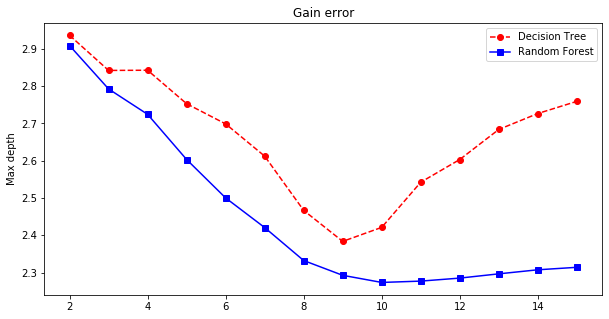

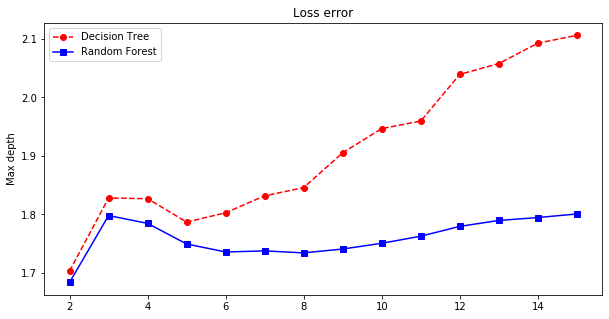

In [8]:
plotGainError()
plotLossError()